# 🌩️ Cloudburst Prediction Prototype (Noida)
This notebook processes **ERA5, IMERG, DEM** data and builds a baseline ML model for cloudburst detection.

First Env check will perform..

In [1]:

import sys
print("✅ Python executable in use:")
print(sys.executable)
print("✅ Python version:")

✅ Python executable in use:
c:\ProgramData\miniconda3\envs\cloud_data\python.exe
✅ Python version:


In [2]:

import os
env_name = os.environ.get("CONDA_DEFAULT_ENV", "Unknown")
print(f"✅ Active Conda environment: {env_name}")


✅ Active Conda environment: cloud_data


In [3]:
print("=== Checking packages for cloudburst_data (preprocessing) ===")
try:
    import numpy, pandas, xarray, rasterio, geopandas, fiona, shapely
    from osgeo import gdal

    print("✅ numpy:", numpy.__version__)
    print("✅ pandas:", pandas.__version__)
    print("✅ xarray:", xarray.__version__)
    print("✅ rasterio:", rasterio.__version__)
    print("✅ geopandas:", geopandas.__version__)
    print("✅ fiona:", fiona.__version__)
    print("✅ shapely:", shapely.__version__)
    print("✅ GDAL:", gdal.__version__)
except Exception as e:
    print("⚠️ Some preprocessing libraries not available:", e)


=== Checking packages for cloudburst_data (preprocessing) ===
✅ numpy: 2.2.6
✅ pandas: 2.3.2
✅ xarray: 2025.6.1
✅ rasterio: 1.4.3
✅ geopandas: 1.1.1
✅ fiona: 1.10.1
✅ shapely: 2.1.1
✅ GDAL: 3.10.3


In [4]:

print("=== Checking DEM tools ===")
try:
    import richdem
    print("✅ RichDEM available")
except ImportError:
    try:
        import whitebox
        print("⚠️ RichDEM not found, but Whitebox available")
    except ImportError:
        print("❌ Neither RichDEM nor Whitebox available")


=== Checking DEM tools ===
✅ RichDEM available


c:\ProgramData\miniconda3\envs\cloud_data\lib\site-packages\richdem\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:

print("=== Checking packages for cloudburst_ml (ML/DL) ===")
try:
    import sklearn, xgboost
    print("✅ scikit-learn:", sklearn.__version__)
    print("✅ xgboost:", xgboost.__version__)
except Exception as e:
    print("⚠️ ML libraries missing:", e)

try:
    import torch
    print("✅ PyTorch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("   GPU:", torch.cuda.get_device_name(0))
except Exception as e:
    print("⚠️ PyTorch not available:", e)

try:
    import tensorflow as tf
    print("✅ TensorFlow:", tf.__version__, "GPU available:", tf.test.is_gpu_available())
except Exception as e:
    print("⚠️ TensorFlow not available:", e)


=== Checking packages for cloudburst_ml (ML/DL) ===
✅ scikit-learn: 1.7.1
✅ xgboost: 3.0.4
⚠️ PyTorch not available: No module named 'torch'
⚠️ TensorFlow not available: No module named 'tensorflow'


In [6]:

# === 1. Setup ===
import os
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import richdem as rd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Paths
ERA5_PATH_instant = "data/data_raw/era5/data_stream-oper_stepType-instant.nc"
ERA5_PATH_accum = "data/data_raw/era5/data_stream-oper_stepType-accum.nc"
IMERG_PATH = "data/data_raw/imerg/3B-HHR.MS.MRG.3IMERG.20240701-S000000-E002959.0000.V07B.HDF5.nc4"
DEM_PATH = "data/data_raw/dem/noida.tif"

os.makedirs("data/data_processed", exist_ok=True)


This sub-step will verify ERA5 file

In [7]:
import xarray as xr

# Change path to your file
ERA5_file_instant = ERA5_PATH_instant
ERA5_file_accum = ERA5_PATH_accum

ds = xr.open_dataset(ERA5_file_instant)

# Quick summary
print("\n🔎 Dataset Info:")

print("📂 Global Attributes:")
print(ds.attrs)

print("\n📏 Dimensions:")
print(ds.dims)

print("\n📊 Variables:")
print(list(ds.data_vars))

print(ds)

ds.close()
ds = xr.open_dataset(ERA5_file_accum)

print("📂 Global Attributes:")
print(ds.attrs) 

print("\n📊 Variables:")
print(list(ds.data_vars))
ds.close()



🔎 Dataset Info:
📂 Global Attributes:
{'GRIB_centre': 'ecmf', 'GRIB_centreDescription': 'European Centre for Medium-Range Weather Forecasts', 'GRIB_subCentre': np.int64(0), 'Conventions': 'CF-1.7', 'institution': 'European Centre for Medium-Range Weather Forecasts', 'history': '2025-09-01T18:49 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes-2.42.0 with {"source": "tmpfgzoz2gp/data.grib", "filter_by_keys": {"stream": ["oper"], "stepType": ["instant"]}, "encode_cf": ["parameter", "time", "geography", "vertical"]}'}

📏 Dimensions:
FrozenMappingWarningOnValuesAccess({'valid_time': 744, 'latitude': 4, 'longitude': 4})

📊 Variables:
['d2m', 't2m', 'sp', 'cape']
<xarray.Dataset> Size: 208kB
Dimensions:     (valid_time: 744, latitude: 4, longitude: 4)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2024-07-01 ... 2024-07-31T23:...
  * latitude    (latitude) float64 32B 28.95 28.7 28.45 28.2
  * longitude   (longitude) float64 32B 76.9 77.15 77.4 77.65
    

This sub-step will verify IMERG data

In [8]:
import xarray as xr
import matplotlib.pyplot as plt

# Change to your IMERG file path
file_path = IMERG_PATH

# Open dataset
ds = xr.open_dataset(file_path)

# --- Quick details ---
print("📂 Global Attributes:")
print(ds.attrs)

print("\n📏 Dimensions:")
print(ds.dims)

print("\n📊 Variables:")
print(list(ds.data_vars))

print("\n🔎 Dataset Info:")
print(ds)

# --- Quick plot of precipitationCal ---
if "precipitationCal" in ds.data_vars:
    var = ds["precipitationCal"].isel(time=0)  # pick first time step
    plt.figure(figsize=(10, 5))
    var.plot(cmap="Blues", cbar_kwargs={"label": "Rainfall (mm/hr)"})
    plt.title("IMERG PrecipitationCal Snapshot (time=0)")
    plt.show()
else:
    print("\n⚠️ 'precipitationCal' variable not found in this file.")

ds.close()


📂 Global Attributes:
{'FileHeader': 'DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauthority=http://dx.doi.org/;\nDOIshortName=3IMERGHH;\nAlgorithmID=3IMERGHH;\nAlgorithmVersion=3IMERGH_7.0;\nFileName=3B-HHR.MS.MRG.3IMERG.20240701-S000000-E002959.0000.V07B.HDF5;\nSatelliteName=MULTI;\nInstrumentName=MERGED;\nGenerationDateTime=2025-01-10T04:36:31.000Z;\nStartGranuleDateTime=2024-07-01T00:00:00.000Z;\nStopGranuleDateTime=2024-07-01T00:29:59.999Z;\nGranuleNumber=;\nNumberOfSwaths=0;\nNumberOfGrids=1;\nGranuleStart=;\nTimeInterval=HALF_HOUR;\nProcessingSystem=PPS;\nProductVersion=V07B;\nEmptyGranule=NOT_EMPTY;\nMissingData=;\n', 'FileInfo': 'DataFormatVersion=7e;\nTKCodeBuildVersion=0;\nMetadataVersion=7e;\nFormatPackage=HDF5-1.10.9;\nBlueprintFilename=GPM.V7.3IMERGHH.blueprint.xml;\nBlueprintVersion=BV_69;\nTKIOVersion=3.101;\nMetadataStyle=PVL;\nEndianType=LITTLE_ENDIAN;\n', 'history': '2025-09-01 18:29:59 GMT hyrax-1.17.1 https://gpm1.gesdisc.eosdis.nasa.gov/opendap/GPM_L3/GPM_3IMERGHH.07/2024/1

This sub-step will verify DEM data

In [9]:
import rasterio

with rasterio.open(DEM_PATH) as dem:
    print("DEM bounds:", dem.bounds)
    print("Resolution:", dem.res)
    print("Shape:", dem.height, "x", dem.width)

DEM bounds: BoundingBox(left=76.99986111111112, bottom=27.999861111111112, right=78.0001388888889, top=29.00013888888889)
Resolution: (0.0002777777777777778, 0.0002777777777777778)
Shape: 3601 x 3601


In [10]:
# === 2. Load ERA5 ===
import xarray as xr

# Paths to downloaded files
instant_file = ERA5_PATH_instant
accum_file   = ERA5_file_accum

# Open datasets
ds_instant = xr.open_dataset(instant_file)
ds_accum   = xr.open_dataset(accum_file)

# Merge them
era5 = xr.merge([ds_instant, ds_accum])

# Now select all variables
era5_df = era5[["t2m","d2m","tp","cape","sp"]].to_dataframe().reset_index()
era5_df.head()


,valid_time,latitude,longitude,t2m,d2m,tp,cape,sp,number,expver
0,2024-07-01,28.95,76.90,301.616180,299.846954,0.001644,568.068848,97017.843750,0,0001
1,2024-07-01,28.95,77.15,301.733032,300.081818,0.002416,590.826660,97049.656250,0,0001
2,2024-07-01,28.95,77.40,301.764709,300.248993,0.001395,583.178223,97058.671875,0,0001
3,2024-07-01,28.95,77.65,301.844818,300.151276,0.000278,623.295410,97068.078125,0,0001
4,2024-07-01,28.70,76.90,301.595917,299.859558,0.000580,702.014160,97058.218750,0,0001


In [11]:

# === 3. Load IMERG ===
imerg = xr.open_dataset(IMERG_PATH)
print(imerg)
# Resample to hourly
imerg_hourly = imerg.resample(time="1h").mean()
imerg_hourly["cloudburst"] = (imerg_hourly["precipitation"] >= 50).astype(int)
imerg_df = imerg_hourly[["precipitation","cloudburst"]].to_dataframe().reset_index()
imerg_df.head()


<xarray.Dataset> Size: 2kB
Dimensions:                    (time: 1, lon: 10, lat: 9)
Coordinates:
  * lat                        (lat) float32 36B 28.15 28.25 ... 28.85 28.95
  * lon                        (lon) float32 40B 76.95 77.05 ... 77.75 77.85
  * time                       (time) object 8B 2024-07-01 00:00:00
Data variables:
    IRprecipitation            (time, lon, lat) float32 360B ...
    precipitationQualityIndex  (time, lon, lat) float32 360B ...
    precipitation              (time, lon, lat) float32 360B ...
    randomError                (time, lon, lat) float32 360B ...
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauth...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    history:                         2025-09-01 18:29:59 GMT hyrax-1.17.1 htt...
    history_json:                    [{"$schema":"https:\/\/harmony.earthdata...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nReg

,time,lon,lat,precipitation,cloudburst
0,2024-07-01 00:00:00,76.949997,28.150000,0.0,0
1,2024-07-01 00:00:00,76.949997,28.250000,0.0,0
2,2024-07-01 00:00:00,76.949997,28.349998,0.0,0
3,2024-07-01 00:00:00,76.949997,28.449999,0.0,0
4,2024-07-01 00:00:00,76.949997,28.549999,0.0,0


DEM bounds: BoundingBox(left=76.99986111111112, bottom=27.999861111111112, right=78.0001388888889, top=29.00013888888889) Resolution: (0.0002777777777777778, 0.0002777777777777778)


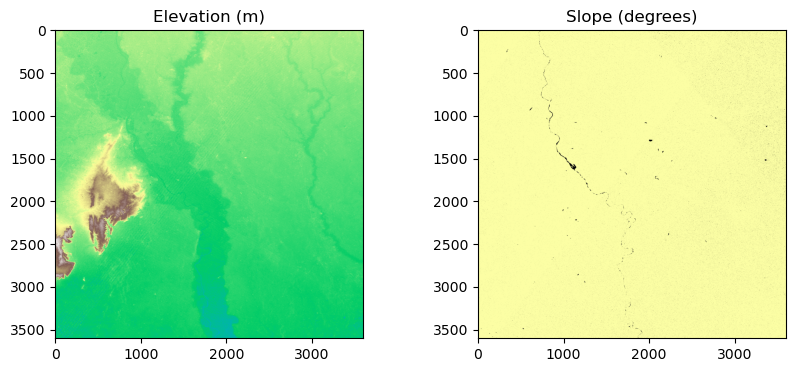

In [12]:

# === 4. Load DEM ===
with rasterio.open(DEM_PATH) as src:
    dem_array = src.read(1)
    bounds = src.bounds
    res = src.res
    print("DEM bounds:", bounds, "Resolution:", res)

dem_rd = rd.LoadGDAL(DEM_PATH)
slope_array = rd.TerrainAttribute(dem_rd, attrib='slope_degrees')

# Quick plots
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].imshow(dem_array, cmap='terrain')
axes[0].set_title("Elevation (m)")
axes[1].imshow(slope_array, cmap='inferno')
axes[1].set_title("Slope (degrees)")
plt.show()


In [13]:

# === 5. Merge ERA5 + IMERG ===
merged = pd.merge(era5_df, imerg_df, on="time", how="inner")

# Add average DEM features (for Noida region)
merged["elevation"] = np.nanmean(dem_array)
merged["slope"] = np.nanmean(slope_array)

print(merged.head())
print("Dataset shape:", merged.shape)

# Save to CSV
merged.to_csv("data/data_processed/noida_training_dataset.csv", index=False)
print("✅ Training dataset saved: data/data_processed/noida_training_dataset.csv")


KeyError: 'time'

In [ ]:

# === 6. Train Baseline ML Model ===
X = merged[["t2m","d2m","tp","cape","sp","elevation","slope"]]
y = merged["cloudburst"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:

# === 7. Visualization ===
plt.figure(figsize=(10,5))
plt.plot(imerg_df["time"], imerg_df["precipitationCal"], label="Rainfall (mm/hr)")
plt.axhline(50, color='r', linestyle='--', label="Cloudburst threshold (50 mm/hr)")
plt.legend()
plt.title("IMERG Rainfall Time Series (Noida)")
plt.xlabel("Time")
plt.ylabel("Rainfall (mm/hr)")
plt.show()
